In [1]:
###%pylab inline
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors as ml_colors
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import os,sys

In [2]:
sys.path.append('/home/ecoon/research/arctic/ats-python/src/models')
import ewc
import wrm_vangenuchten
import permafrost_model_explicit_fpd

In [3]:
class TC(object):

    def thermal_conductivity(self, poro, sl, si):
        raise RuntimeError("class TC is not implemented")
    
    def plot_end_members(self, poro, s_r, axs=None, color='k', label=None, npoints=1000):
        if axs is None:
            fig = plt.figure(figsize=(4,8))
            axs = []
            axs.append(fig.add_subplot(311))
            axs.append(fig.add_subplot(312))
            axs.append(fig.add_subplot(313))
    
        # unfrozen
        sle = np.linspace(0,1,npoints)
        sl = sle*(1-s_r) + s_r
        si = 0
        tc_u = np.array([self.thermal_conductivity(poro, s, si) for s in sl])
        axs[0].plot(sle, tc_u, color=color, label=label)
        axs[0].set_xlabel("1 - reduced gas saturation")
        axs[0].set_title("T > 0")
        axs[0].set_ylabel("thermal conductivity")
    
        # frozen
        sie = np.linspace(0,1,1000)
        si = sie*(1-s_r)
        tc_f = np.array([self.thermal_conductivity(poro, s_r, s) for s in si])
        axs[1].plot(sie, tc_f, color=color, label=label)
        axs[1].set_xlabel("1 - reduced gas saturation")
        axs[1].set_title("T << 0")
        axs[1].set_ylabel("thermal conductivity")
        
        # transition
        sie = np.linspace(0,1,1000)
        si = sie*(1-s_r)
        tc_t = np.array([self.thermal_conductivity(poro, 1-s, s) for s in si])
        axs[2].plot(sie, tc_t, color=color, label=label)
        axs[2].set_xlabel("reduced ice saturation")
        axs[2].set_ylabel("thermal conductivity")
        axs[2].set_title("sg = 0")
        
    def plot_pcolor(self, poro, s_r, ax=None):
    
        sle = np.linspace(0,1,100)
        sie = np.linspace(0,1,100)

        sl = sle*(1-s_r) + s_r
        si = sie*(1-s_r)
        TC = np.array([[self.thermal_conductivity(poro, k,j) for k in sl] for j in si])
        if ax is None:
            fig = plt.figure()
            ax = fig.add_subplot(111)
        ax.imshow(TC, origin='lower')
        ax.set_xlabel("reduced liquid saturation")
        ax.set_ylabel("reduced ice saturation")
        return TC
        
    def plot_surf(self, poro, s_r, fig, ax=None):
    
        sle = np.linspace(0,1,100)
        sie = np.linspace(0,1,100)

        sl = sle*(1-s_r) + s_r
        si = sie*(1-s_r)
        TC = np.array([[self.thermal_conductivity(poro, k,j) for k in sl] for j in si])

        if ax is None:
            ax = fig.add_subplot(111,projection="3d")
        
        cmap = cm.jet
        vmin = np.min(np.where(np.isnan(TC),1.e10,TC))
        vmax = np.max(np.where(np.isnan(TC),-1.e10,TC))
        norml = ml_colors.Normalize(vmin=vmin, vmax=vmax, clip = True)
        
        SLE,SIE = np.meshgrid(sle,sie)
        surf = ax.plot_surface(SLE, SIE, TC, rstride=1, cstride=1, cmap=cmap, norm=norml, 
                               linewidth=0, antialiased=False)

        ax.set_xlabel("reduced liquid saturation")
        ax.set_ylabel("reduced ice saturation")
        ax.set_zlabel("thermal conductivity")
        fig.colorbar(surf,shrink=0.5,aspect=5)
        return TC, ax        
        

        

In [4]:
class PetersLidard(TC):
    d_ = 0.053
    eps_ = 1.e-10
    
    def __init__(self, a_u, a_f, k_soil, k_gas=0.024, k_liq=0.5611, k_ice=2.27742):
        self.a_u = a_u
        self.a_f = a_f
        self.k_soil = k_soil
        self.k_gas = k_gas
        self.k_liq = k_liq
        self.k_ice = k_ice
        
    def thermal_conductivity(self, poro, sl, si):
        if sl + si > 1: return np.nan
        k_dry = (self.d_*(1-poro)*self.k_soil + self.k_gas*poro) / \
            (self.d_*(1-poro) + poro)
        k_sat_u = pow(self.k_soil,(1-poro)) * pow(self.k_liq,poro)
        k_sat_f = pow(self.k_soil,(1-poro)) * pow(self.k_ice,poro)
        kersten_u = pow(sl + self.eps_, self.a_u)
        kersten_f = pow(si + self.eps_, self.a_f)

        return kersten_f * k_sat_f + kersten_u * k_sat_u + (1.0 - kersten_f - kersten_u) * k_dry
 

In [5]:
class PetersLidard2(TC):
    d_ = 0.053
    eps_ = 1.e-10
    
    def __init__(self, a_u, a_f, k_soil, k_gas=0.024, k_liq=0.5611, k_ice=2.27742):
        self.a_u = a_u
        self.a_f = a_f
        self.k_soil = k_soil
        self.k_gas = k_gas
        self.k_liq = k_liq
        self.k_ice = k_ice
        
    def thermal_conductivity(self, poro, sl, si):
        if sl + si > 1: return np.nan
        k_dry = (self.d_*(1-poro)*self.k_soil + self.k_gas*poro) / \
            (self.d_*(1-poro) + poro)
        k_sat_u = pow(self.k_soil,(1-poro)) * pow(self.k_liq,poro)
        k_sat_f = pow(self.k_soil,(1-poro)) * pow(self.k_ice,poro)
        kersten_u = pow(sl + self.eps_, self.a_u)
        kersten_f = pow(si + self.eps_, self.a_f)

        k_f = kersten_f * k_sat_f + (1-kersten_f)*k_dry
        k_u = kersten_u * k_sat_u + (1-kersten_u)*k_dry
        uf = sl / (sl + si)
        
        return uf*k_u + (1-uf)*k_f
 

/Users/uec/codes/anaconda/2/5.1.0/base/lib/python2.7/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


/Users/uec/codes/anaconda/2/5.1.0/base/lib/python2.7/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


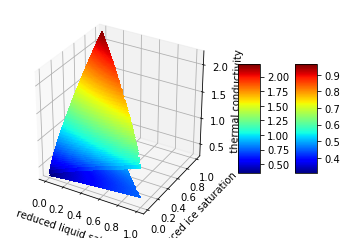

In [6]:
fig = plt.figure()
tc_peat = PetersLidard(0.397947, 2.00553, 0.107283)
vals,ax = tc_peat.plot_surf(0.876418, 0.345733, fig)

tc_soil = PetersLidard(0.797355, 0.732066, 2.32081)
tc_soil.plot_surf(0.59611, 0.199097, fig, ax)

plt.show()

In [8]:
poro_peat = 0.85
sr_peat = 0.3
poro_soil = 0.6
sr_soil = 0.1

print('peat:',tc_peat.thermal_conductivity(poro_peat, 1,0))
print('soil:',tc_soil.thermal_conductivity(poro_soil, 1,0))

('peat:', 0.4377880117599548)
('soil:', 0.99010223770549)
